In [20]:
import os
import numpy as np
import pygame
import pygame.gfxdraw
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from collections import defaultdict

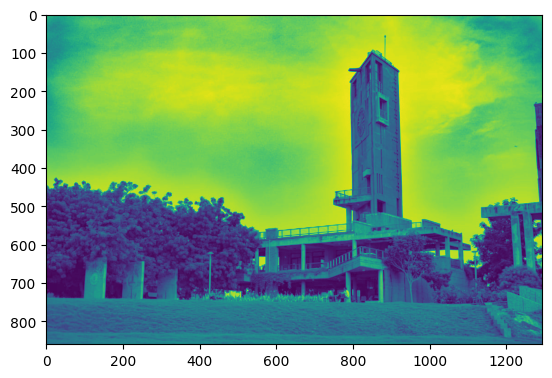

In [21]:
inp = pygame.surfarray.pixels3d(pygame.image.load("lal_minar.png"))
perceptual_weight = np.array([0.2126, 0.7152, 0.0722])
grayscale = (inp * perceptual_weight).sum(axis=-1)
plt.imshow(grayscale.T);

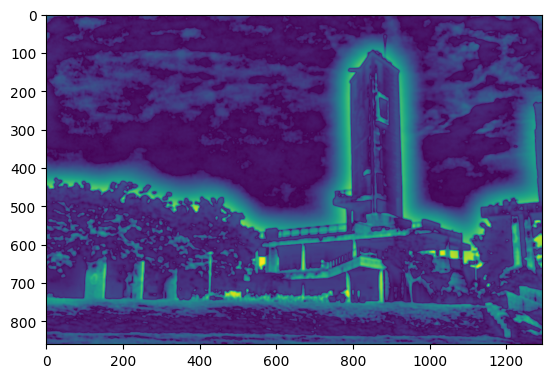

In [22]:
x = gaussian_filter(grayscale, 2, mode="reflect")
x2 = gaussian_filter(grayscale, 30, mode="reflect")

# Take the difference, deweight negatives, normalise
diff = (x - x2)
diff[diff < 0] *= 0.1
diff = np.sqrt(np.abs(diff) / diff.max())

plt.imshow(diff.T)

In [23]:
def sample(ref, n=1000000):
    np.random.seed(0)
    w, h = x.shape
    xs = np.random.randint(0, w, size=n)
    ys = np.random.randint(0, h, size=n)
    value = ref[xs, ys]
    accept = np.random.random(size=n) < value
    points = np.array([xs[accept], ys[accept]])
    return points.T, value[accept]

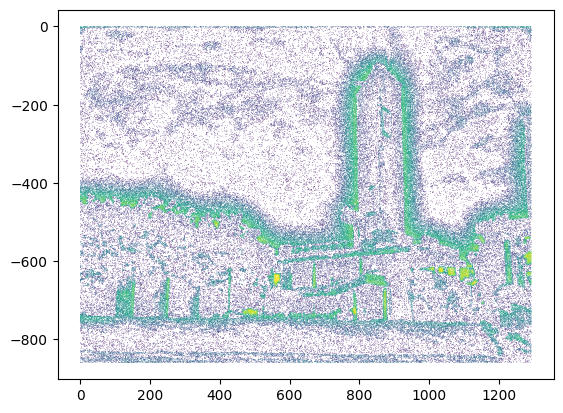

In [24]:
samples, v = sample(diff)
plt.scatter(samples[:, 0], -samples[:, 1], c=v, s=0.2, edgecolors="none", cmap="viridis")

In [25]:
def get_colour_of_tri(tri, image):
    colours = defaultdict(lambda: [])
    w, h, _ = image.shape
    for i in range(0, w):
        for j in range(0, h):
            # Gets the index of the triangle the point is in
            index = tri.find_simplex((i, j))
            colours[int(index)].append(inp[i, j, :])
    # For each triangle, find the average colour
    for index, array in colours.items():
        colours[index] = np.array(array).mean(axis=0)
    return colours

In [26]:
def draw(tri, colours, screen, upscale):
    s = screen.copy()
    for key, c in colours.items():
        t = tri.points[tri.simplices[key]]
        pygame.gfxdraw.filled_polygon(s, t * upscale, c)
        pygame.gfxdraw.polygon(s, t * upscale, c)
    return s

In [28]:
w, h, _ = inp.shape
upscale = 2
screen = pygame.Surface((w * upscale, h * upscale))
screen.fill(inp.mean(axis=(0, 1)))
corners = np.array([(0, 0), (0, h - 1), (w - 1, 0), (w - 1, h - 1)])
points = np.concatenate((corners, samples))

outdir = "lowpoly/"
os.makedirs(outdir, exist_ok=True)

for i in range(80, 100+1, 5):
    n = 5 + i + 2 * int(i**2)
    tri = Delaunay(points[:n, :])
    colours = get_colour_of_tri(tri, inp)
    s = draw(tri, colours, screen, upscale)
    s = pygame.transform.smoothscale(s, (w, h))
    pygame.image.save(s, f"lowpoly/{i:04d}.png")